<a href="https://colab.research.google.com/github/vhinatav/IAT360_FinalProject/blob/main/ToxicCommentModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TOXIC COMMENT MODEL**

Our project focuses on training and fine-tuning an NLP model that detects toxic comments, such as hate speech, harassment, or abusive language, in online communications by fine-tuning BERT (bert-based-uncased), a bidirectional transformer-based pre-trained language model introduced by Google in 2018 (reference: https://huggingface.co/google-bert/bert-base-uncased).


Addressing this issue is crucial in today’s digital era, where social media plays a significant role in daily life, and many people fall victim to cyberbullying and harmful online interactions. Toxic comments affect one’s mental health, disrupt healthy engagement between people, and create unsafe online environments. By developing this model, we aim to foster respectful digital spaces that benefit users, communities, and platforms alike. The model can be applied in real-life scenarios, including social media, online education, workplace communication tools, and gaming communities, contributing to safer and more inclusive online interactions.

# **Preparation**

## Libraries

In [1]:
!pip install numpy torch datasets transformers evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==3.2.0
evaluate==0.4.3
numpy==1.26.4
torch @ https://download.pytorch.org/whl/cu121_full/torch-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-linux_x86_64.whl
torchsummary==1.5.1
torchvision @ https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-linux_x86_64.whl
transformers==4.46.3


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import torch
import os
import evaluate
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from PIL import Image

## Data

In [4]:
# Load the dataset
from datasets import load_dataset

# Original Datasets are available at https://huggingface.co/datasets/SetFit/toxic_conversations
# Modified Datasets are available at https://huggingface.co/datasets/vhinatav/360toxicdata20000
raw_dataset = load_dataset('ct0314/360toxicdata30000')
raw_dataset

# get train and validation set
dataset = raw_dataset['train'].train_test_split(test_size=0.2, seed=42, shuffle=True)
dataset

# rename validation key to 'val'
dataset['val'] = dataset['test']
dataset

# copy test set from raw_dataset
dataset['test'] = raw_dataset['test']
dataset

# Load pre-trained BERT tokenizer
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
tokenizer

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

def tokenization(example):
    return tokenizer(example['text'], truncation=True, padding="max_length", max_length = 256)

tokenized_dataset = dataset.map(tokenization, batched=True, remove_columns=['text'])
tokenized_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.jsonl:   0%|          | 0.00/8.95M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/2.28M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23999 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/19199 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 19199
    })
    test: Dataset({
        features: ['label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 6000
    })
    val: Dataset({
        features: ['label', 'label_text', 'input_ids', 'attention_mask'],
        num_rows: 4800
    })
})

## Evaluation Metrics

In [5]:
# Load evaluation metrics
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    return {**accuracy, **f1}

## BERT Model

In [6]:
# Load pre-trained BERT model
num_labels = 2
id2label = {0: 'NON_TOXIC', 1: 'TOXIC'}
label2id = {'NON_TOXIC': 0, 'TOXIC': 1}
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Training**

## Training 1 (First Iteration)

Dataset Size: 1500 rows (https://huggingface.co/datasets/vhinatav/360toxicdata / Epochs: 3 / Batch Size: 32

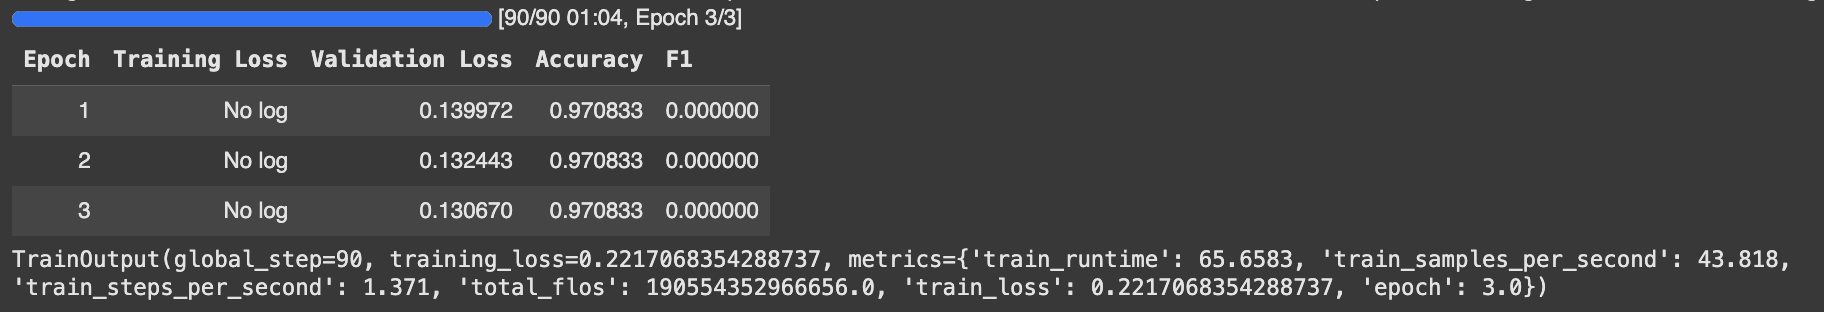

In [ ]:
Image.open('/content/Training_Results/Training_1.png')

## Training 2 (Increased Dataset)

Dataset Size: 20000 rows / Epochs: 3 / Batch Size: 32

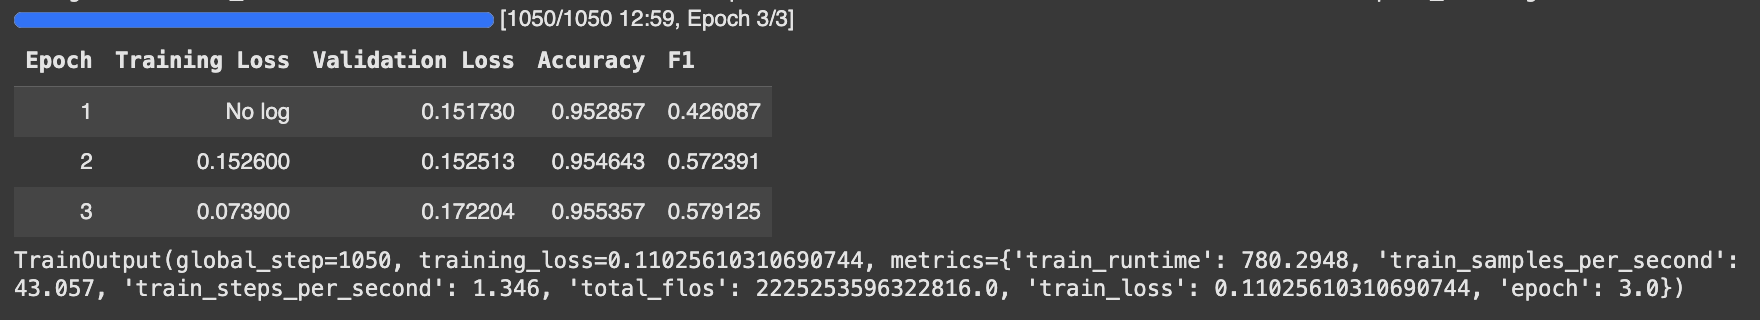

In [ ]:
Image.open('/content/Training_Results/Training_2.png')

## Training 3 (Increased Epochs)

Dataset Size: 20000 rows / Epochs: 5 / Batch Size: 32

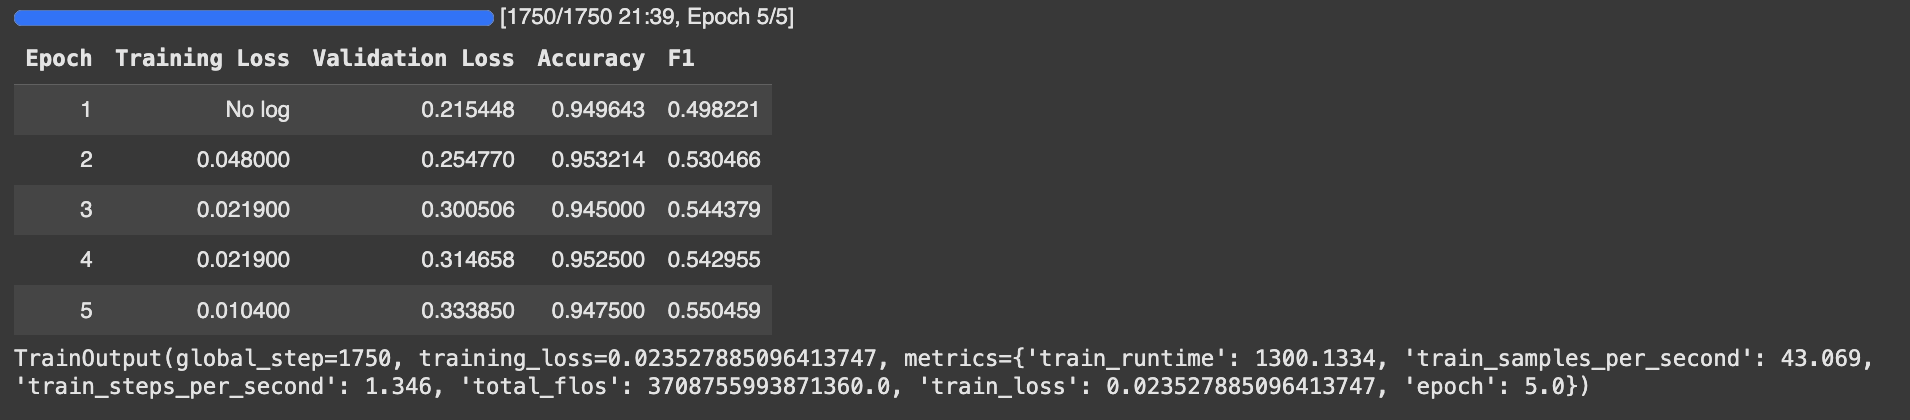

In [ ]:
Image.open('/content/Training_Results/Training_3.png')

## Training 4 (Decreased Batch Size)

Dataset Size: 20000 rows / Epochs: 5 / Batch Size: 8

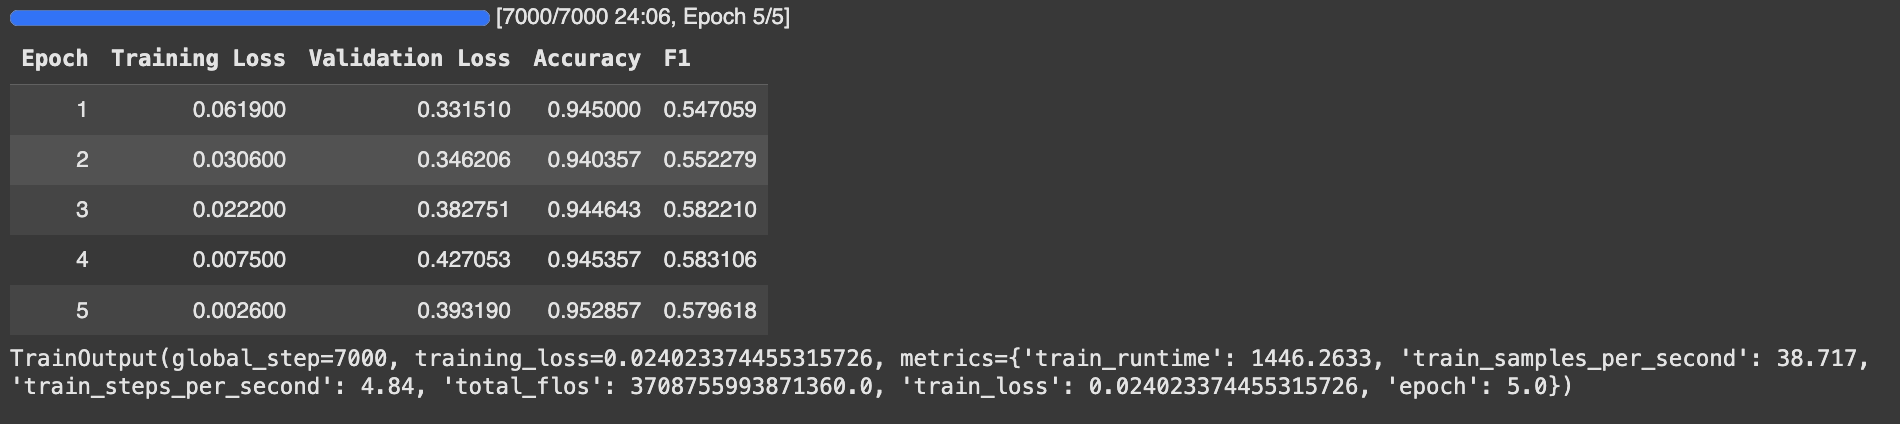

In [13]:
Image.open('/content/Training_Results/Training_4.png')

## Training 5 (Increased Dataset, Increased Epoch, and Added Learning Rate) - **FINAL MODEL**

Dataset Size: 30000 rows / Epochs: 10 / Batch Size: 8

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    save_strategy="no",
    logging_dir="./logs",
)

# Step 7: Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    compute_metrics=compute_metrics,
)

# Disable W&B logging
os.environ['WANDB_DISABLED'] = "true"

# Train the model
trainer.train()

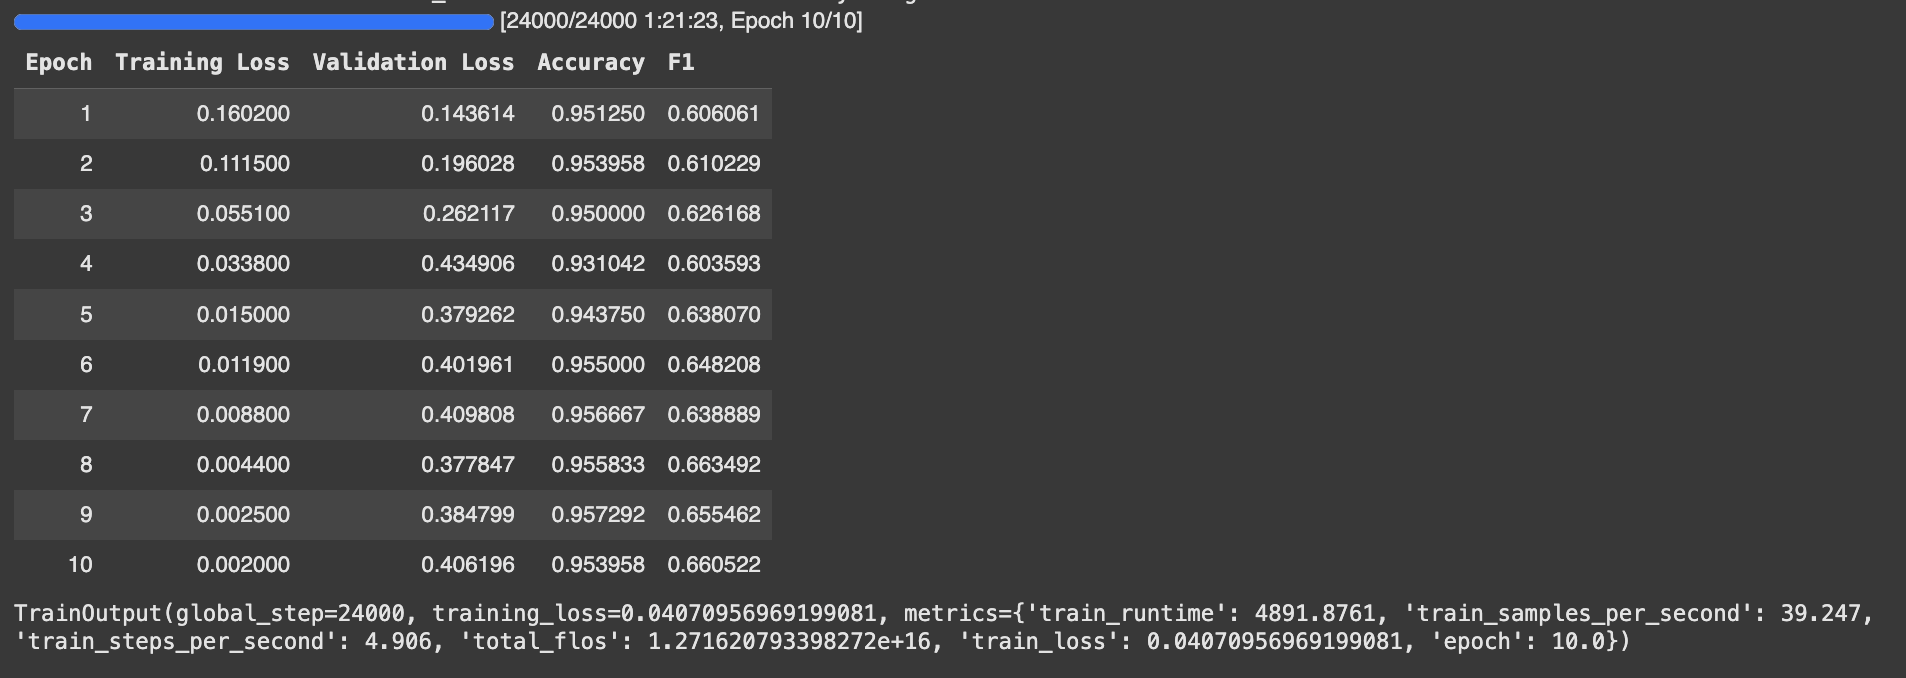

In [23]:
Image.open('/content/Training_Results/Training_5.png')

## Training 6 (Decreased Epoch)

Dataset Size: 30000 rows / Epochs: 5 / Batch Size: 8

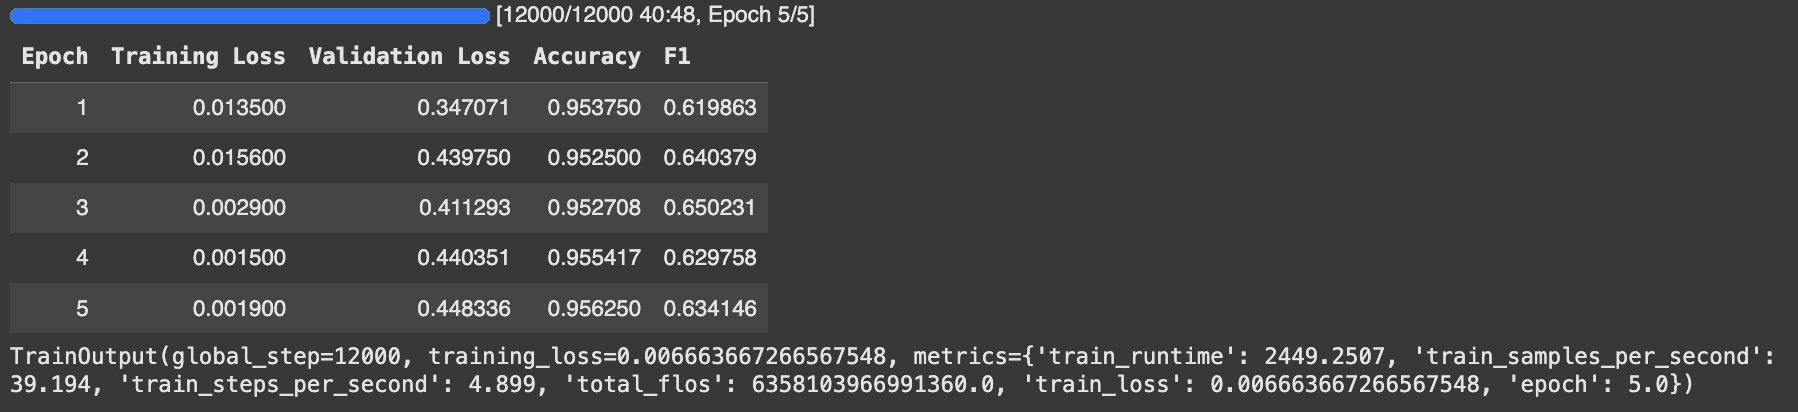

In [20]:
Image.open('/content/Training_Results/Training_6.png')

# **Evaluation**

In [16]:
# Evaluate the fine-tuned model
results = trainer.evaluate(tokenized_dataset['test'])
print(results)

{'eval_loss': 0.5100135803222656, 'eval_accuracy': 0.9515, 'eval_f1': 0.5637181409295352, 'eval_runtime': 44.7526, 'eval_samples_per_second': 134.07, 'eval_steps_per_second': 16.759, 'epoch': 5.0}


## Confusion Matrix

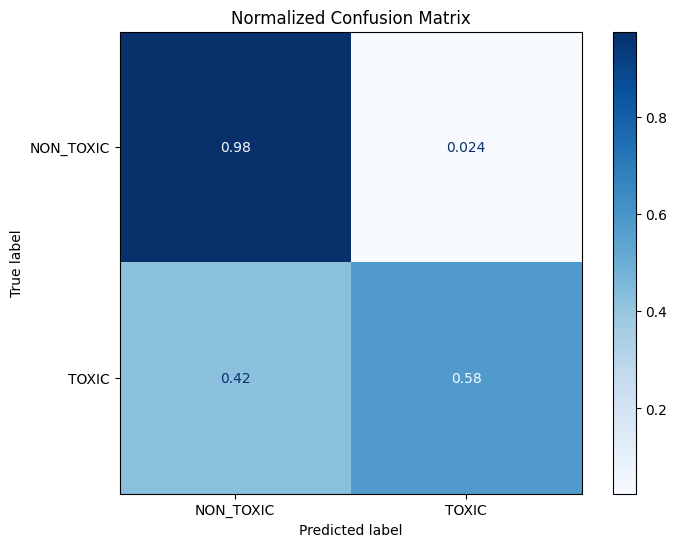

In [9]:
#AI tool was referenced to assist with a portion of the code in this part.

# Confusion Matrix Visualization
predictions = trainer.predict(tokenized_dataset['test'])
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Save confusion matrix as an image
cm_fig = plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['NON_TOXIC', 'TOXIC'])
disp.plot(cmap=plt.cm.Blues, ax=cm_fig.gca())
plt.title('Normalized Confusion Matrix')
confusion_matrix_path = './confusion_matrix_normalized.png'
plt.savefig(confusion_matrix_path)
plt.show()

# Display the confusion matrix as an image
confusion_matrix_image = Image.open(confusion_matrix_path)
confusion_matrix_image.show()

## F1 Curve

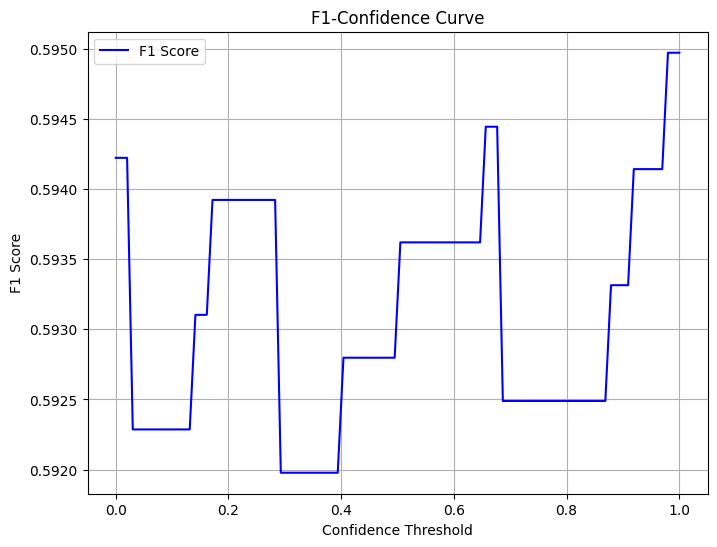

<Figure size 640x480 with 0 Axes>

In [10]:
#AI tool was referenced to assist with a portion of the code in this part.

# Get predictions (probabilities)
predictions = trainer.predict(tokenized_dataset['test'])
predicted_probs = predictions.predictions  # These are the raw prediction scores (probabilities)

# Get the true labels
true_labels = predictions.label_ids

# Calculate the F1 score at different confidence thresholds
confidence_thresholds = np.linspace(0, 1, 100)
f1_scores = []

for threshold in confidence_thresholds:
    # Convert probabilities to class predictions based on the threshold
    predicted_labels = (predicted_probs[:, 1] >= threshold).astype(int)

    # Compute F1 score for this threshold
    f1 = f1_score(true_labels, predicted_labels)
    f1_scores.append(f1)

# Plot the F1-Confidence Curve
plt.figure(figsize=(8, 6))
plt.plot(confidence_thresholds, f1_scores, label='F1 Score', color='blue')
plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1-Confidence Curve')
plt.grid(True)
plt.legend()
plt.show()

# Optionally, save the plot
f1_curve_path = './f1_confidence_curve.png'
plt.savefig(f1_curve_path)

# Display the saved image
f1_curve_image = Image.open(f1_curve_path)
f1_curve_image.show()

# **Pipeline**

In [15]:
# Set up pipeline for toxic comment classification
toxic_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)
device = torch.cuda.current_device()

# Create a pipeline for the toxic comment classifier
toxic_classifier = pipeline(
    task='text-classification',
    model=model,
    tokenizer="distilbert-base-uncased",
    device=device
)

def classify_user_input():
  print("Enter 'quit' to stop the program,")

  while True:
    # Get user input
    user_input = input("Enter a comment for toxicity classification: ")

    # If the user types 'quit', exit the loop
    if user_input.lower() == 'quit':
      print("Exiting...")
      break

    # Classify the input comment
    result = toxic_classifier([user_input])[0]

    # Print the result
    print(f"Comment: {user_input}")
    print(f"Prediction: {result['label']}(Score: {result['score']:.4f})\n")

# Call the function
classify_user_input()

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Enter 'quit' to stop the program,
Enter a comment for toxicity classification: I like you!
Comment: I like you!
Prediction: NON_TOXIC(Score: 1.0000)

Enter a comment for toxicity classification: Stupid!
Comment: Stupid!
Prediction: TOXIC(Score: 1.0000)

Enter a comment for toxicity classification: quit
Exiting...
